# Нейросеть СNN - LSTM для распознавания тематики книги по обложке

Используем созданную модель для работы: определим тему книг, собранных из билиотеки за 1998 г, 50 шт каждой темы (ограничились малым числом для более быстрой обработки и препроцессинга данных). Один из классов отсутствовал в этом году. 

In [24]:
import numpy as np
import keras
from keras.models import Model, Sequential
from keras.layers import LSTM, Conv2D, BatchNormalization, AveragePooling2D, Flatten, TimeDistributed
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
IMG_SIZE = (224, 224)

In [22]:
import re
from random import shuffle
from glob import glob
import pandas as pd

all_files = glob('*.jpg')

Модель тренировалась для темы: религия, поэтому отберу только столбец 'religion'

In [8]:
ff = pd.DataFrame(all_files, columns=['fname'])

ff - датафрейм чтобы проверить, что есть все файлы из загруженной таблицы; пустые записи удалим.

загрузим заранее подготовленный файл с классами и номером изображения

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

subj_list = ['children', 'fantasy','medicine', 'music','mystery and detective stories', 
             'recipes', 'religion', 'romance', 'science','science fiction']

df = pd.read_csv('title_cover.csv')
df['path'] = df.file.apply(lambda x: 'allfiles'+'\\'+x )
df.head()

,Unnamed: 0,children,childrentxt,cover_id,fantasy,fantasytxt,medicine,medicinetxt,music,musictxt,...,romancetxt,science,science fiction,science fictiontxt,sciencetxt,title,words,title_len,file,path
0,0,1.0,children,575546.0,1.0,fantasy,0.0,0,0.0,0,...,0,0.0,0.0,0,0,alice s adventures in wonderland,"['alice', 'adventure', 'wonderland']",3,575546.jpg,allfiles\575546.jpg
1,1,1.0,children,1981419.0,0.0,0,0.0,0,0.0,0,...,0,0.0,0.0,0,0,the personal history of david copperfield,"['personal', 'history', 'david', 'copperfield']",4,1981419.jpg,allfiles\1981419.jpg
2,2,1.0,children,1321813.0,0.0,0,0.0,0,0.0,0,...,0,0.0,0.0,0,0,wizard of oz,"['wizard', 'oz']",2,1321813.jpg,allfiles\1321813.jpg
3,3,1.0,children,2964863.0,0.0,0,0.0,0,0.0,0,...,0,0.0,0.0,0,0,the turn of the screw,"['turn', 'screw']",2,2964863.jpg,allfiles\2964863.jpg
4,4,1.0,children,311182.0,0.0,0,0.0,0,0.0,0,...,0,0.0,0.0,0,0,a child s garden of verses,"['child', 'garden', 'verse']",3,311182.jpg,allfiles\311182.jpg


In [78]:
books = df.merge(ff, left_on='file', right_on='fname', how='inner') 
# inner,  чтобы взять те файлы, которые точно есть и папке с файлами и в df

In [79]:
y = np.array(df['religion'])
X = books['file']

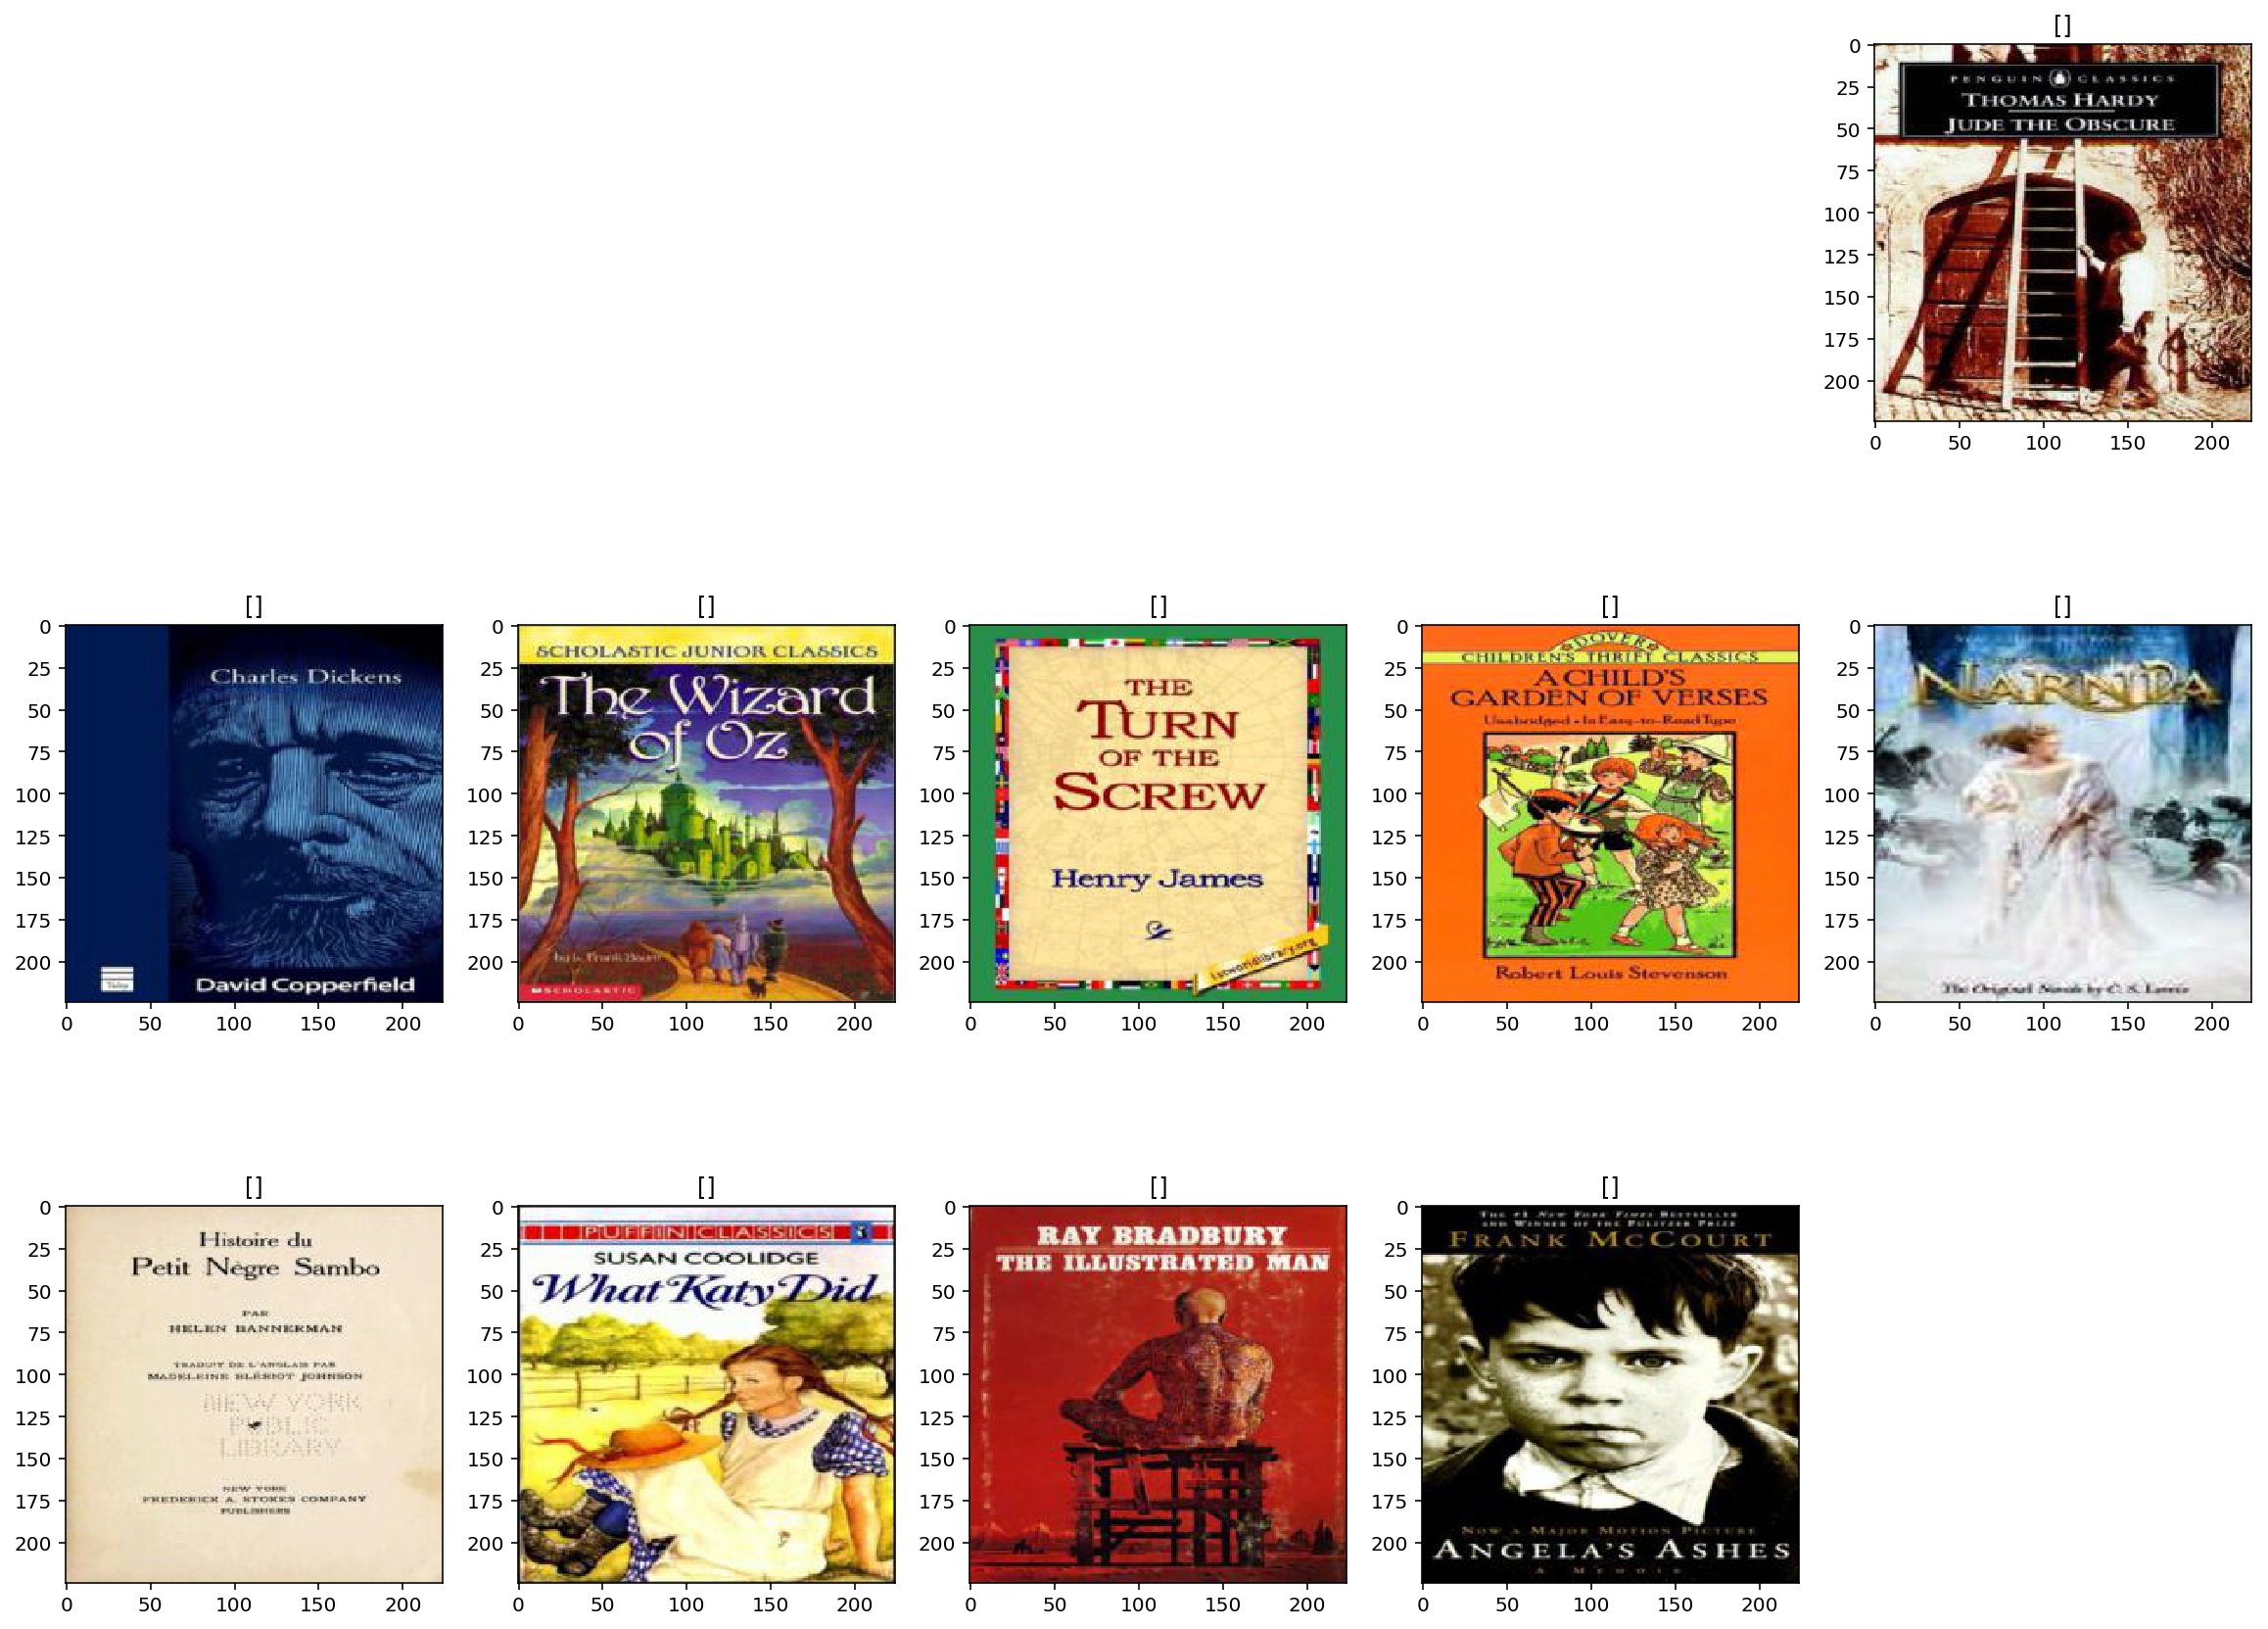

In [68]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i in range(1, 11):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(X[i]));
    book_title = []
    if y[i] !=0:
            #print(j, subj_list[j])
        book_title.append('religion')
    subplot.set_title('%s' %  str(book_title)); # поправить вывод названия
    
plt.show()

In [26]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [27]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False
#optimizer = RMSprop(1e-3)

In [28]:
x = base_model.output 
x = keras.layers.TimeDistributed(Flatten())(x)
x = keras.layers.LSTM(2048, input_shape=(2048,None), return_sequences=True, activation = 'relu')(x)
x = keras.layers.Dropout(0.2) (x)
x = keras.layers.LSTM(1024,  return_sequences=True, activation = 'relu')(x)
x = keras.layers.Dropout(0.2) (x)
x = keras.layers.LSTM(512, return_sequences=True, activation = 'relu')(x)
x = keras.layers.Dropout(0.2) (x)
x = keras.layers.LSTM(256, return_sequences=True, activation = 'relu') (x)
x = keras.layers.Dropout(0.2) (x)
x = keras.layers.LSTM(128, activation = 'relu')(x)
x = keras.layers.Dropout(0.2) (x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                )(x) 

model = Model(inputs=base_model.input, outputs=x)

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [21]:
model.compile(optimizer=RMSprop(1e-3), loss='binary_crossentropy',  metrics=['accuracy'])
#checkp = ModelCheckpoint(filepath='weights_lstm_relig_2000 1 vers.best.cover.hdf5', 
#                               verbose=1, save_best_only=True)

In [31]:
model.load_weights('weights_lstm_relig_2000+1+vers.best.cover.hdf5')

In [52]:
proba = model.predict_generator(predict_generator(X), len(X), max_queue_size=100)

In [58]:
proba

array([[0.54277205],
       [0.58824843],
       [0.4218646 ],
       [0.6351644 ],
       [0.48912892],
       [0.5900236 ],
       [0.68802774],
       [0.22505465],
       [0.6438623 ],
       [0.606695  ],
       [0.5036057 ],
       [0.8693049 ],
       [0.7120229 ],
       [0.6260531 ],
       [0.5675344 ],
       [0.58224106],
       [0.62605906],
       [0.5663111 ],
       [0.70349354],
       [0.50184584],
       [0.47809374],
       [0.65588146],
       [0.5100783 ],
       [0.63218814],
       [0.5141144 ],
       [0.48091996],
       [0.678352  ],
       [0.46918744],
       [0.596812  ],
       [0.56060123],
       [0.49756396],
       [0.45317313],
       [0.63121015],
       [0.5140251 ],
       [0.51547354],
       [0.5105616 ],
       [0.6982808 ],
       [0.51554275],
       [0.3010012 ],
       [0.3128971 ],
       [0.5996565 ],
       [0.16302302],
       [0.48650888],
       [0.47680524],
       [0.5938086 ],
       [0.5944067 ],
       [0.50934386],
       [0.485

In [59]:
y = np.array(df['religion'])

In [65]:
pred

array([[9.9215746e-01],
       [5.5391436e-05],
       [7.5175065e-01],
       ...,
       [8.5255915e-01],
       [6.3263327e-01],
       [7.5781834e-01]], dtype=float32)

In [37]:
y_pred= np.round(pred)

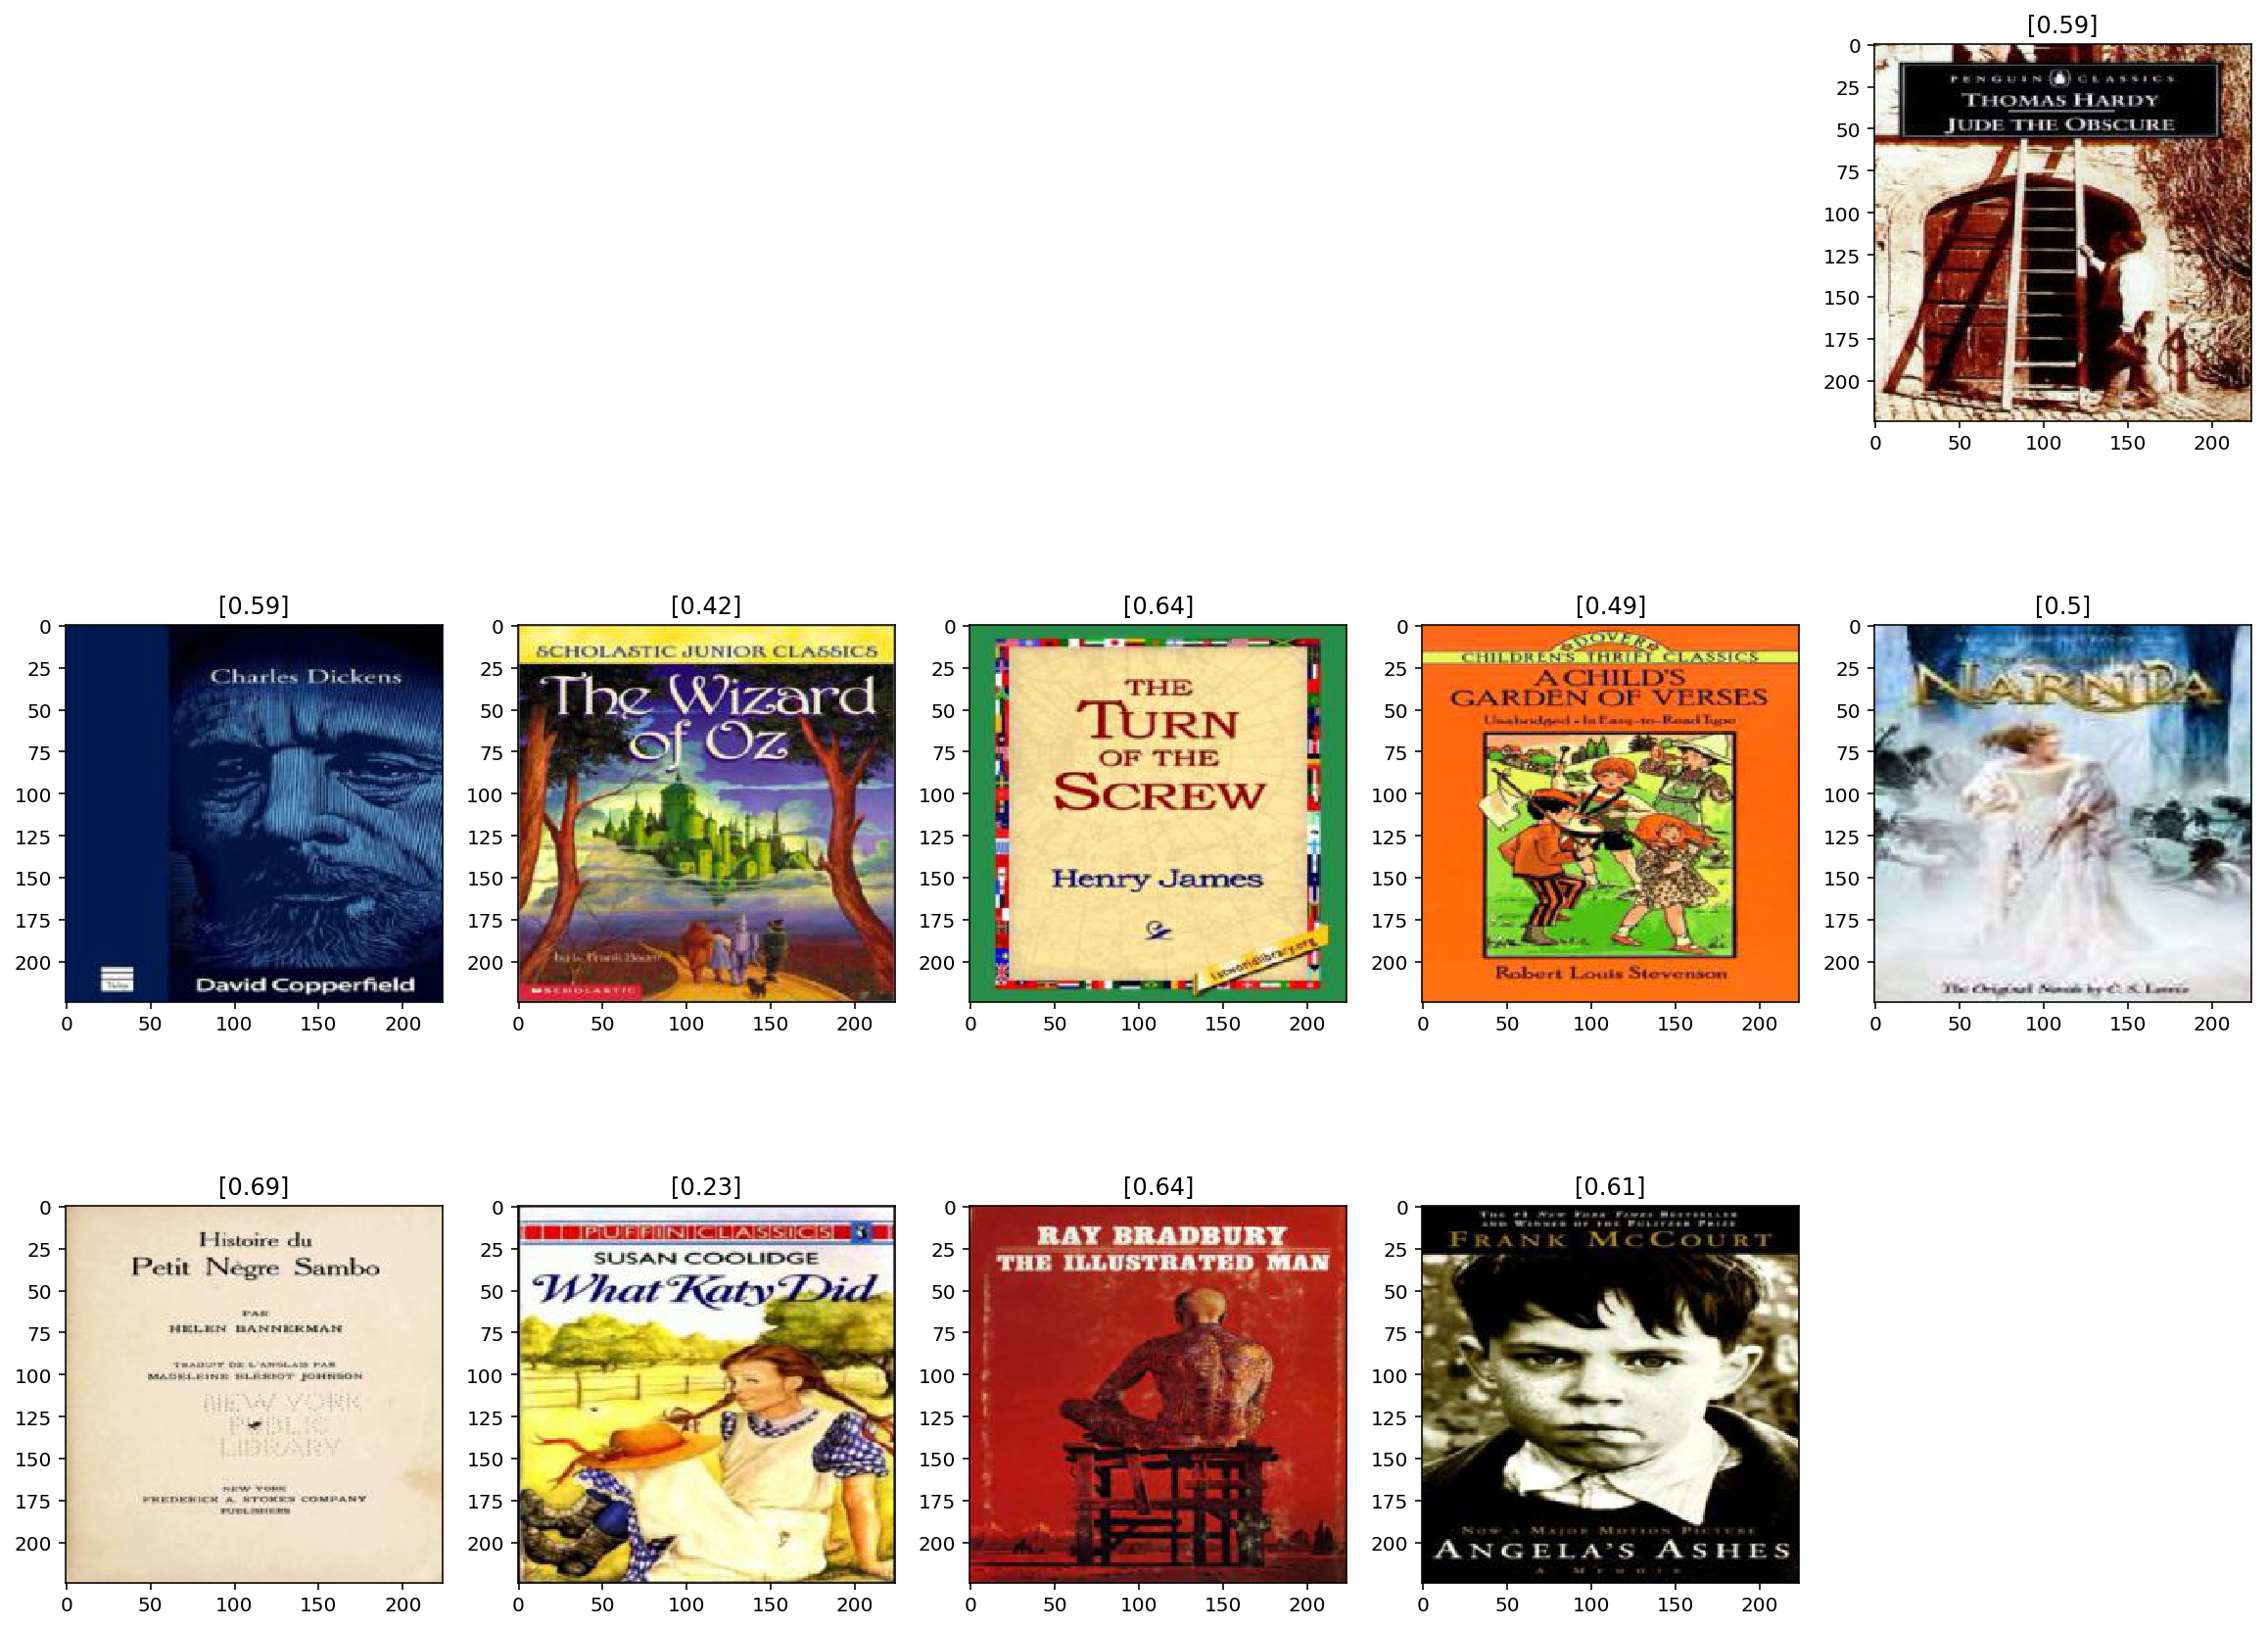

In [66]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i in range(1, 11):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(X[i]));
    book_title = ()
    if y[i] !=0:
        book_title = 'religion. '+ str(np.around(proba[i],decimals= 2))
    else:
        book_title = str(np.around(proba[i], decimals = 2))
    subplot.set_title(book_title); # поправить вывод названия
    
plt.show()

In [62]:
pred_class = np.around(proba)

In [63]:
from sklearn.metrics import *
import sklearn as skl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (10, 7)

summary = classification_report(y, pred_class)
print(summary)

             precision    recall  f1-score   support

        0.0       0.97      0.44      0.60       322
        1.0       0.12      0.83      0.21        29

avg / total       0.90      0.47      0.57       351



In [83]:
relig_books = books['religion'][books.religion ==1].sum()
print('Тема религия: {:.0f}. Все остальное: {:.0f}. Отношение классов {:.2f}'.
      format(relig_books, books.shape[0]-relig_books, relig_books/books.shape[0] ))

Тема религия: 29. Все остальное: 322. Отношение классов 0.08


Precision для искомого класса мал, однако, точность его нахождения велика. Возникает вопрос: в чем дело?
Все просто: выборку формировала таким образом: выбрав год, брали по каждой тематике 50 книг, один из классов не был 
        представлен в библиотеке за этот год (1998). Поэтому среди всех классов присутствуют книге по теме религия
        только в небольшом соотношении. Как показано выше - это 0,08 от всех книг. Что очень близко к precision и 
        доказывают хорошую работу созданной модели

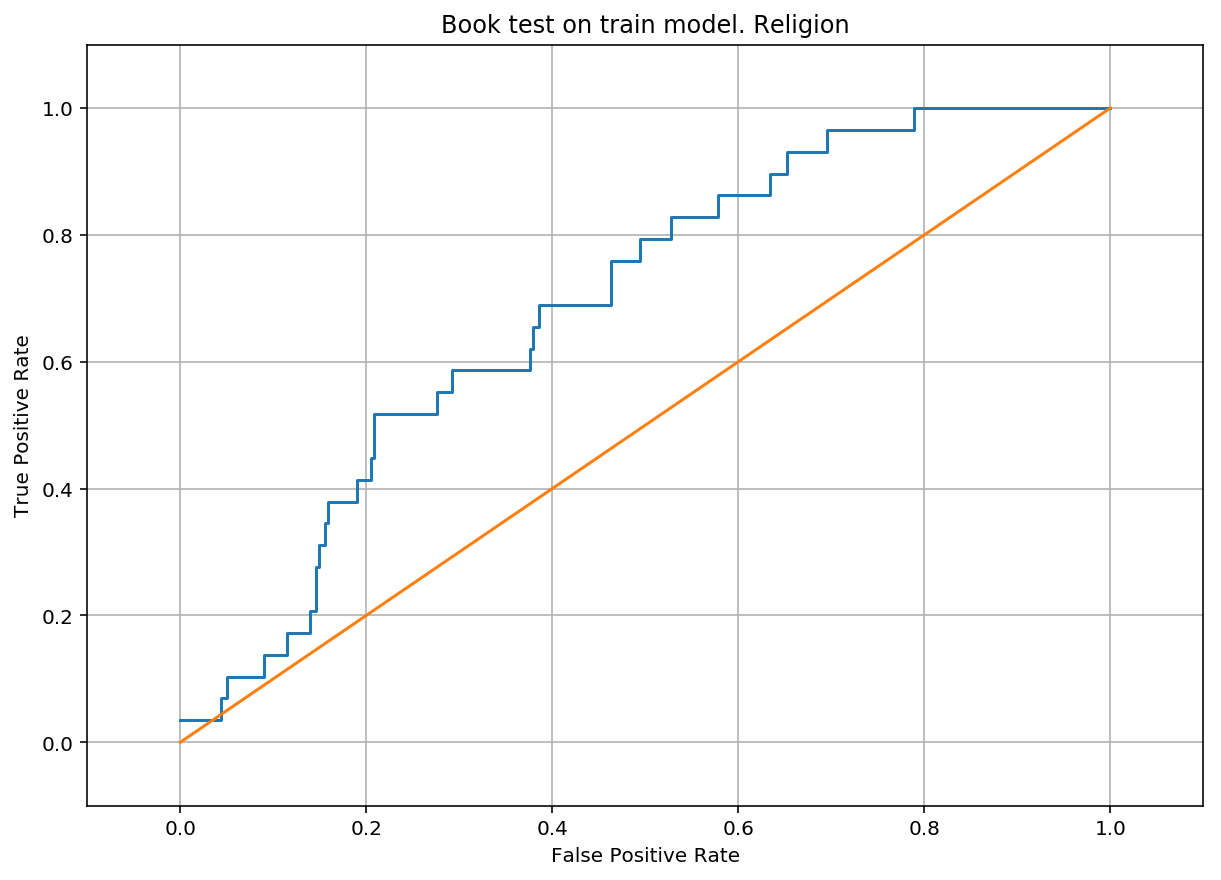

In [64]:
fpr, tpr, thresholds = roc_curve(y, proba)
fig = plt.figure()
plt.plot( fpr, tpr)    
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Book test on train model. Religion')
plt.grid()
plt.show()
fig.savefig('Book test on train model LSTM', dpi = 300, bbox_inches='tight')
print();